In [1]:
# Import several packages that will be used throughout

# numeric packages
import numpy as np
import scipy
import scipy.io
import pandas as pd

import h5py
import cPickle as pickle
import gzip

# filesystem and OS
import sys, os, time
import glob

# plotting
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

import keras
from keras import backend as K

sys.path.append("/home/adalbert/nbserver/urban-environments/keras-utils/")
sys.path.append("/home/adalbert/nbserver/urban-environments/keras-models/")
import keras_utils as ku
from multi_gpu import make_parallel

sys.path.append("../../spatial_transformer_networks/src/")
from spatial_transformer import SpatialTransformer

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
workdir = "/home/adalbert/nbserver/tf-workspace/urban-atlas-experiments/"

if not os.path.exists(workdir):
    os.makedirs(workdir)
    
os.chdir(workdir)

# Set up data sources 

In [3]:
train_dir = "/home/adalbert/data/urban-atlas/extracted-data/"

In [4]:
def load_data_sources(cities):

    # load paths to source images

    files = np.array([f for c in cities for f in glob.glob(train_dir + "%s/img/*/*.jpg"%c)])
    files_df =  pd.DataFrame(files).rename(columns={0:"filename"})
    files_df['class'] = files_df['filename'].apply(lambda x: x.split("/")[-2])
    files_df['city'] = files_df['filename'].apply(lambda x: x.split("/")[-4])
    files_df['phase'] = files_df['filename'].apply(lambda x: "validation" if "grid" in x else "training")

    # consolidate classes to work with

    consolidate_classes = {
        "Continuous Urban Fabric (S.L. > 80%)":"High Density Urban Fabric",
         "Discontinuous Dense Urban Fabric (S.L. : 50% -  80%)":"High Density Urban Fabric",
         "Discontinuous Medium Density Urban Fabric (S.L. : 30% - 50%)":"Medium Density Urban Fabric",
         "Discontinuous Low Density Urban Fabric (S.L. : 10% - 30%)":"Low Density Urban Fabric",
         "Discontinuous Very Low Density Urban Fabric (S.L. < 10%)":"Low Density Urban Fabric"
    }
    files_df['class'] = files_df['class'].apply(
        lambda x: consolidate_classes[x] if x in consolidate_classes else x)

    # TODO!!!
    # there is a bug here -- the high density urban fabric is not included (because of the 'continuous' below)!!
    # another bug: medium density does not exist!
    include_classes = ["Green urban areas", 
                       "Airports",
                       "Forests",
                       "Agricultural + Semi-natural areas + Wetlands",
                       # "Railways and associated land",
                       "High Density Urban Fabric", 
                        #"Mineral extraction and dump sites",
                       "Medium Density Urban Fabric", 
                       "Low Density Urban Fabric",
                       "Water bodies",
                       "Sports and leisure facilities",
                       "Industrial, commercial, public, military and private units"]
    files_df = files_df[files_df['class'].isin(include_classes)]

    return files_df

In [5]:
cities = ["athina", "berlin", "budapest", "roma", "barcelona", "madrid"]

files_df = load_data_sources(cities)

# update classes dictionary if needed

classes = files_df['class'].unique()
classes.sort()
class2label = {c:i for i,c in enumerate(classes)}
label2class = {i:c for i,c in enumerate(classes)}
N_CLASSES = len(classes)
print N_CLASSES

with gzip.open("classes.pickle.gz", "w") as f:
    pickle.dump({"class2label":class2label, "label2class":label2class}, f)

# class_weights = get_class_weights(files_df['class'].apply(lambda x: class2label[x]))
class_weights = {i:1 for i in range(N_CLASSES)}

10


### Split into train & test

In [6]:
FRAC_TRAIN = 0.8

def split_train_test(my_files_df, frac_train=0.8, save_prefix=""):

    train_df = my_files_df.sample(int(len(my_files_df) * frac_train))
    test_df  = my_files_df[~my_files_df.index.isin(train_df.index)]

    print "Train: %d; Test: %d"%(len(train_df), len(test_df))

    train_df.to_csv("%strain.csv"%save_prefix, index=False)
    test_df.to_csv("%stest.csv"%save_prefix, index=False)

    return train_df, test_df

In [7]:
mycities = cities
my_files_df = files_df[files_df['city'].isin(mycities)]

train_df, test_df = split_train_test(my_files_df, frac_train=0.8)

Train: 147531; Test: 36883


In [8]:
train_df['class'].value_counts()

Agricultural + Semi-natural areas + Wetlands                  32906
High Density Urban Fabric                                     30367
Industrial, commercial, public, military and private units    18804
Forests                                                       17367
Medium Density Urban Fabric                                   14384
Low Density Urban Fabric                                      10686
Green urban areas                                              8501
Sports and leisure facilities                                  8083
Water bodies                                                   4638
Airports                                                       1795
Name: class, dtype: int64

In [9]:
test_df['class'].value_counts()

Agricultural + Semi-natural areas + Wetlands                  8317
High Density Urban Fabric                                     7543
Industrial, commercial, public, military and private units    4693
Forests                                                       4458
Medium Density Urban Fabric                                   3480
Low Density Urban Fabric                                      2588
Green urban areas                                             2181
Sports and leisure facilities                                 2034
Water bodies                                                  1141
Airports                                                       448
Name: class, dtype: int64

### Set up batching

The data is stored in folders in the format "/city/class-name/city_zoom_lat_lon.jpg". It's not feasible to try to separate the data into train/test beforehand, this should be done via files for train/test with file paths when training the model.


In [50]:
BATCH_SIZE = 100

# Generator for preprocessing images for data augmentation

from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
train_augmenter_norot = ImageDataGenerator(
        rescale=1./255, 
        zoom_range=[1,1.2],
        vertical_flip=True,
        horizontal_flip=True)

train_augmenter = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.10,
        zoom_range=[1,1.2],
        vertical_flip=True,
        rotation_range=15,
        horizontal_flip=True)

test_augmenter = ImageDataGenerator(rescale=1./255)


In [51]:
tr_gen = ku.generator_from_file("berlin-train.csv", \
                                      image_generator=train_augmenter_norot, \
                                      class_dict = class2label,\
                                      balance = 1,
                                      #crop=42,
                                      #downsample=2,
                                      new_img_shape=(224,224), 
                                      batch_size=BATCH_SIZE)
ts_gen = ku.generator_from_file("berlin-test.csv", \
                                      image_generator=test_augmenter, \
                                      class_dict = class2label,\
                                      #crop=42,
                                      balance = 1,
                                      #downsample=2,
                                      new_img_shape=(224,224), 
                                      batch_size=BATCH_SIZE)
i = 0
for X, y in tr_gen:
    print (X.min(), X.max(), X.sum(), X.dtype), X.shape, y.argmax(1).sum()
    i += 1
    if i > 5:
        break
    

(0.0, 1.0, 10675727.548467416, dtype('float64')) (100, 224, 224, 3) 470
(0.0, 1.0, 10352356.934324164, dtype('float64')) (100, 224, 224, 3) 473
(0.0, 1.0, 10494244.913017325, dtype('float64')) (100, 224, 224, 3) 442
(0.0, 1.0, 10378382.061281692, dtype('float64')) (100, 224, 224, 3) 490
(0.0, 1.0, 10572793.585607529, dtype('float64')) (100, 224, 224, 3) 437
(0.0, 1.0, 10300411.921822809, dtype('float64')) (100, 224, 224, 3) 427


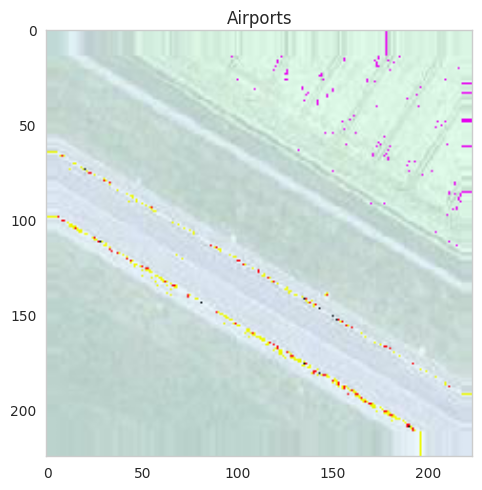

In [52]:
plt.imshow(X[0,:,:,:])
plt.title(label2class[y[0].argmax()])

# Define architectures

This uses models previously trained on the DeepSat benchmark.

In [13]:
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D

def build_locnet(input_shape):
    # initial weights
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((50, 6), dtype='float32')
    weights = [W, b.flatten()]

    locnet = Sequential()
    locnet.add(MaxPooling2D(pool_size=(2,2), input_shape=input_shape))
    locnet.add(Convolution2D(20, 5, 5))
    locnet.add(MaxPooling2D(pool_size=(2,2)))
    locnet.add(Convolution2D(20, 5, 5))

    locnet.add(Flatten())
    locnet.add(Dense(50))
    locnet.add(Activation('relu'))
    locnet.add(Dense(6, weights=weights))
    return locnet

In [14]:
def add_spatial_transformer(model, locnet, output_size):
    newmodel = Sequential()
    newmodel.add(SpatialTransformer(localization_net=locnet,
                                 output_size=output_size, 
                                 input_shape=input_shape))
    newmodel.add(model)
    return newmodel

#### VGG16 model pre-trained on DeepSat data

In [15]:
from keras.layers import Dense, Flatten
from keras.models import Model, Sequential

def setup_vgg16(n_classes, model_file):
    # load model and weights
    model = keras.models.load_model(model_file)

    # there's a bug in how Keras handles popping layers for net surgery
    # even if the last layer is popped, the model still believes its output shape is the old one
    # see https://github.com/fchollet/keras/issues/2371
    model.layers.pop() # Get rid of the classification layer
    model.outputs = [model.layers[-1].output]
    model.output_layers = [model.layers[-1]] # added this line in addition to zo7 solution
    model.layers[-1].outbound_nodes = []

    # add new top model for classification over Urban Atlas classes
    top_model = Dense(n_classes, input_shape=model.layers[-1].output_shape[1:], 
                  activation='softmax', name="dense8_new")
    model.add(top_model)
    
    return model

model_file_vgg16 = "../deepsat-experiments/vgg16-deepsat-imagenet-best-checkpoint.h5"

#### Resnet-50 model pre-trained on DeepSat data

In [16]:
from keras.layers import Dense

def setup_resnet50(n_classes, model_file):

    model = keras.models.load_model(model_file)

    model.layers.pop() # Get rid of the classification layer
    model.outputs = [model.layers[-1].output]
    model.output_layers = [model.layers[-1]] # added this line in addition to zo7 solution
    model.layers[-1].outbound_nodes = []

    newClassificationLayer = Dense(N_CLASSES, activation='softmax')(model.layers[-1].output)
    model = Model(input=model.input, output=newClassificationLayer)
    
    return model

model_file_resnet50 = "../deepsat-experiments/resnet-deepsat-imagenet-best-checkpoint.h5"

# Define training protocol

In [17]:
import re

def fn_get_acc(filename):
    reg = r"-(\d.+)-"
    match = re.search(reg, filename)
    return float(filename[match.start():match.end()].replace("-",""))


In [18]:
from keras.optimizers import SGD, RMSprop, Adadelta, Adagrad, Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard

GPUS = [0,1,2,3]
BASE_LR = 0.1
LR_DECAY_PER_EPOCH = 2.0 #1.1

def train_cycle(model, train_generator, test_generator, fix_base=True, save_prefix="", nb_epochs=50):
    
    # control whether to train on 
    trainable_layers = [l.name for l in model.layers if len(l.get_weights())>0 ]
    for l in model.layers:
        l.trainable = (not fix_base) or (l.name == trainable_layers[-1])

    # this uses the TensorFlow backend to spread computation on multiple GPUs
    model_gpu = make_parallel(model, GPUS)

    # compile model
    model_gpu.compile(loss='categorical_crossentropy', \
                  metrics=['accuracy', 'precision', 'recall'],\
                  optimizer=Adadelta(lr=BASE_LR))

    # Logs to TensorBoard, new one for each run
    log_path_tensorboard = "./logs/"
    now = time.strftime("%c")
    tensorboard_callback_fn = TensorBoard(log_dir=log_path_tensorboard + now + "-" + save_prefix, \
                                    histogram_freq=0, \
                                    write_graph=True, \
                                    write_images=False)

    
    # callback to checkpoint best model
    ckpt_file = "%s-{val_acc:.2f}-checkpoint.h5"%save_prefix
    model_checkpoint_callback = ModelCheckpoint(ckpt_file, monitor='val_acc', \
                                                verbose=1, save_best_only=True, mode='max')

    # callback for a custom learning rate decay schedule

    lr_scheduler = lambda epoch: BASE_LR * LR_DECAY_PER_EPOCH**(-(epoch/10))
    lr_decay_callback = keras.callbacks.LearningRateScheduler(lr_scheduler)

    # early stopping callback
    earlystopping_callback = keras.callbacks.EarlyStopping(monitor='val_acc', \
                                                           min_delta=1e-4, \
                                                           patience=10, verbose=0, mode='auto')
    lr_reducer_callback = ReduceLROnPlateau(monitor='val_loss', \
                                            factor=np.sqrt(0.1), \
                                            cooldown=0, patience=5, \
                                            min_lr=0.5e-6)

    # train model
    history = model_gpu.fit_generator(
                train_generator,
                samples_per_epoch=2000,
                class_weight=class_weights,
                nb_epoch=nb_epochs,
                validation_data=test_generator,
                callbacks = [tensorboard_callback_fn, lr_decay_callback, \
                             model_checkpoint_callback, 
                             earlystopping_callback, lr_reducer_callback],
                nb_val_samples=1000)
    
    # return checkpoint of maximum validation accuracy
    model_files = glob.glob("%s-*-checkpoint.h5"%save_prefix)
    checkpoints_dict = {f:fn_get_acc(f) for f in model_files}
    best_checkpoint_file = checkpoints_dict.keys()[checkpoints_dict.values().index(max(checkpoints_dict.values()))]
    return max(history.history['val_acc']), best_checkpoint_file

In [19]:
# Keras won't release GPU memory, so training multiple models within a loop might crash.
# This is a fix that runs each training cycle in its own OS process using the multiprocessing module.
# See via https://github.com/fchollet/keras/issues/2689

from multiprocessing import Process, Queue

def run_in_separate_process(method, args):
    def queue_wrapper(q, params):
        r = method(*params)
        q.put(r)

    q = Queue()
    p = Process(target=queue_wrapper, args=(q, args))
    p.start()
    return_val = q.get()
    p.join()
    return return_val

# another solution is as follows:

# from keras import backend as K
# K.clear_session()


# Regular CNN vs Spatial Transformer

In [56]:
model = keras.models.load_model("./resnet50-urbanatlas-berlin-0.71-checkpoint.h5") 

# model = setup_resnet50(N_CLASSES, "../deepsat-experiments/resnet-deepsat-imagenet-best-checkpoint.h5")

In [57]:
input_shape = (224, 224, 3)
output_shape= (224, 224, 3)

locnet = build_locnet(input_shape)

model_st = add_spatial_transformer(model, locnet, output_shape)

In [58]:
best_acc1, best_checkpoint = train_cycle(model_st, 
                                         tr_gen, ts_gen, 
                                         fix_base=False, 
                                         nb_epochs=20,\
                                         save_prefix="%s-urbanatlas-%s"%("resnet50-ST-all", "berlin"))


Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/20
2000/2000 [==============================] - 51s - loss: 0.9092 - acc: 0.6740 - precision: 0.7745 - recall: 0.5720 - val_loss: 0.9645 - val_acc: 0.6590 - val_precision: 0.7537 - val_recall: 0.5570
Epoch 2/20
2000/2000 [==============================] - 41s - loss: 0.9268 - acc: 0.6610 - precision: 0.7578 - recall: 0.5535 - val_loss: 0.8765 - val_acc: 0.6930 - val_precision: 0.7788 - val_recall: 0.5980
Epoch 3/20
2000/2000 [==============================] - 41s - loss: 0.8890 - acc: 0.6920 - precision: 0.7895 - recall: 0.5905 - val_loss: 0.8329 - val_acc: 0.6790 - val_precision: 0.7600 - val_recall: 0.6120
Epoch 4/20
2000/2000 [==============================] - 41s - loss: 0.8701 - acc: 0.6950 - precision: 0.7986 - recall: 0.5925 - val_loss: 0.8908 - val_acc: 0.6810 - val_precision: 0.7498 - val_recall: 0.6060
Epoch 5/20
2000/2000 [==============================] - 41s - loss: 0.8748 - acc: 0.6945 - precision: 

In [48]:
best_checkpoint

'resnet50-ST-all-urbanatlas-berlin-0.76-checkpoint.h5'

In [49]:
# further train all layers in the network
model = keras.models.load_model(best_checkpoint, custom_objects={'SpatialTransformer': SpatialTransformer})
# best_acc2, best_checkpoint = train_cycle(model, tr_gen, ts_gen, fix_base=False, \
#                                         save_prefix="%s-urbanatlas-%s"%("resnet50-ST", "berlin"))        


TypeError: __init__() takes exactly 3 arguments (1 given)

# Train models: loop through experiments

In [ ]:
# # set up experiments

# cities = ["athina", "berlin", "bucuresti", "tallinn", "barcelona", "dublin"]
# mycities = [[x] for x in cities] + [list(set(cities)-set([c])) for c in cities]

# architectures = [("resnet50", setup_resnet50, model_file_resnet50),
#                  ("vgg16", setup_vgg16, model_file_vgg16)]

In [ ]:
# set up experiments

cities = ["madrid"]
mycities = [[x] for x in cities] 

architectures = [("resnet50", setup_resnet50, model_file_resnet50),
                 ("vgg16", setup_vgg16, model_file_vgg16)]

In [ ]:
mycities

In [ ]:
val_acc_dict = {}

In [ ]:
from keras.optimizers import SGD, RMSprop, Adadelta, Adagrad, Adam
import time

for cur_cities in mycities:
    
    # load data, set up classes
    
    my_files_df = files_df[files_df['city'].isin(cur_cities)]
    save_prefix = "+".join(cur_cities)
    
    # split into test & train
    
    train_df = my_files_df.sample(int(len(my_files_df) * FRAC_TRAIN))
    train_csv= "%s-train.csv"%save_prefix
    train_df.to_csv(train_csv, index=False)

    test_df  = my_files_df[~my_files_df.index.isin(train_df.index)]
    test_csv = "%s-test.csv"%save_prefix
    test_df.to_csv(test_csv, index=False)
    print "%s | train: %d | test: %d"%("+".join(cur_cities), len(train_df), len(test_df))

    # define test & train generators
    
    train_generator = ku.generator_from_file(train_csv, \
                                      image_generator=train_augmenter, \
                                      class_dict = class2label,\
                                      balance = 1,
                                      #downsample=2,
                                      new_img_shape=(224,224), 
                                      batch_size=BATCH_SIZE)
    test_generator  = ku.generator_from_file(test_csv, \
                                          image_generator=test_augmenter, \
                                          balance = 1,
                                          #downsample=2,
                                          class_dict = class2label,\
                                          new_img_shape=(224,224), 
                                          batch_size=BATCH_SIZE)
    # train architectures 
    
    for architecture, fn_setup_architecture, model_file in architectures:
        
        existing_checkpoints = glob.glob("*checkpoint.h5")
        existing_checkpoints = np.unique([f.split("-")[0] + f.split("-")[2] for f in existing_checkpoints])
        if architecture + save_prefix in existing_checkpoints:
            print (architecture, save_prefix), "already computed!"
            continue
        
        # set up model
        K.clear_session()
        model = fn_setup_architecture(N_CLASSES, model_file)    
        
        # train using initial weights, only train top layer for a smaller number of epochs
        # this is because the random initialization might propagate errors down the network
        print "%s | %s | training top layer" % (save_prefix, architecture) 
        best_acc1, best_checkpoint = train_cycle(model, train_generator, test_generator, fix_base=True, nb_epochs=20,\
                                                save_prefix="%s-urbanatlas-%s"%(architecture, save_prefix))
        clear_output(wait=True)
        K.clear_session()
        
        # further train all layers in the network
        print "%s | %s | training all layers" % (save_prefix, architecture) 
        model = keras.models.load_model(best_checkpoint)
        best_acc2, best_checkpoint = train_cycle(model, train_generator, test_generator, fix_base=False, \
                                                save_prefix="%s-urbanatlas-%s"%(architecture, save_prefix))        
        clear_output(wait=True)
        K.clear_session()
        
        # further train all layers in the network starting from best checkpoint
        # looks like this improves the accuracy slightly in experiments
        print "%s | %s | further training" % (save_prefix, architecture) 
        model = keras.models.load_model(best_checkpoint)
        best_acc3, best_checkpoint = train_cycle(model, train_generator, test_generator, fix_base=False, \
                                                save_prefix="%s-urbanatlas-%s"%(architecture, save_prefix))
        clear_output(wait=True)
        K.clear_session()        
        
        val_acc_dict[(save_prefix, architecture)] = (best_acc1, best_acc2, best_acc3)